# Помощник в определении стоимости лота на японском автоаукционе

В чем заключается выбор машины на японском аукционе для российского покупателя? По факту надо рассмотреть все машины, которые предлагают несколько аукционов для покупки на следующие несколько дней, выбрать те на которые хотите сделать ставку, и "угадать" правильную ставку. Количество ставок в день не более 5.   
Сложность в поиске компромисса. Если сделать большую ставку на машину с плохими характеристиками, то эта ставка сыграет сразу, но стоимость будет великовата для качества покупки, а если делать заниженные ставки, то можно играть очень долго, надеясь получить даром "коллекционный" экземпляр.  
Есть различные инструкции, как правильно выбирать, какие ставки делать, какие лоты смотреть в первую очередь. В оценке лота, всегда даются минимальная, максимальная и средняя стоимость продажи таких машин за какой-то период. И есть статистика продаж машин за последние 3 месяца. Все это помогает оценить машину очень приблизительно, но расчет самой ставки остается за покупателем, и чтобы начать более-меннее правильно оценивать, проходит, не меньше месяца.  
Мы имеем набор данных о продажах машин с  их характеристиками за последние 3 месяца, с целевой переменной - стоимость продажи и также имеем несколько машин с их характеристиками, у которых надо определить эту стоимость. Задача контролируемого обучения - линейной регрессии.
Если получится построить хорошую модель, то мы сможем достаточно быстро определять предполагаемую стоимость продажи такой машины и делать правильные ставки с первого дня на аукционе.

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler 

import warnings
warnings.filterwarnings("ignore")

In [127]:
hf = pd.read_excel('auc08_07.xlsx')
ht = pd.read_excel('auc11_07.xlsx')

In [128]:
#hf.columns

In [129]:
# Выкинем лишние столбцы
hf.drop(['date', 'lot', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 17'], axis=1, inplace=True)
ht.drop(['date', 'lot', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 17'], axis=1, inplace=True)

In [130]:
# Удалим строки с нулями в колонках цветов и модификаций
hf.dropna(axis=0, subset=['color'], inplace=True)
ht.dropna(axis=0, subset=['color'], inplace=True)

hf.dropna(axis=0, subset=['mod'], inplace=True)
ht.dropna(axis=0, subset=['mod'], inplace=True)

hf.dropna(axis=0, subset=['score'], inplace=True)
ht.dropna(axis=0, subset=['score'], inplace=True)

In [131]:
# Заменим некоторые редкие и дублированные разноцветия
# Хорошо бы сделать, как сделал с моделями, но отсекает немного данных
hf['color'].replace("actual vehicle", 'WHITE', inplace=True)
hf['color'].replace("P WHITE", 'WHITE', inplace=True)
hf['color'].replace("LIGHT GREEN", 'GREEN', inplace=True)
hf['color'].replace("LIGHT BLUE", 'BLUE', inplace=True)
hf['color'].replace("NAVY BLUE", 'BLUE', inplace=True)
hf['color'].replace("WINE RED", 'RED', inplace=True)
hf['color'].replace("WINE", 'RED', inplace=True)
hf['color'].replace("CRYSTAL BLACK", 'BLACK', inplace=True)

ht['color'].replace("actual vehicle", 'WHITE', inplace=True)
ht['color'].replace("P WHITE", 'WHITE', inplace=True)
ht['color'].replace("LIGHT GREEN", 'GREEN', inplace=True)
ht['color'].replace("LIGHT BLUE", 'BLUE', inplace=True)
ht['color'].replace("NAVY BLUE", 'BLUE', inplace=True)
ht['color'].replace("WINE RED", 'RED', inplace=True)
ht['color'].replace("WINE", 'RED', inplace=True)
ht['color'].replace("CRYSTAL BLACK", 'BLACK', inplace=True)

In [132]:
# В моделях наводим немного порядка, много всяких названий, по сути - 4 основных класса.
# Красиво работают срезы!!!
hf.loc[hf['mod'].str.contains('FA IN'), 'mod'] = 'FA IN LINE'

ht.loc[ht['mod'].str.contains('FA IN'), 'mod'] = 'FA IN LINE'


# Это оставил, чтобы сравнить. Так я делал, но это выбирает и изменяет, без оставления, не знаю куда inplace всунуть
# hf[hf['mod'].str.contains('FA IN')]['mod'].apply(lambda m: 'FA IN LINE')

In [133]:
# Не надо менять местами, делаем по порядку, иначе присвоит классы неверно!
hf.loc[hf['mod'].str.contains('NAVIGATION'), 'mod'] = 'PREM'
hf.loc[hf['mod'].str.contains('PREM'), 'mod'] = 'PREM'

ht.loc[ht['mod'].str.contains('NAVIGATION'), 'mod'] = 'PREM'
ht.loc[ht['mod'].str.contains('PREM'), 'mod'] = 'PREM'

In [134]:
# Продолжаем
hf.loc[hf['mod'].str.contains('SMART'), 'mod'] = 'SMART'
hf.loc[hf['mod'].str.contains('HYBRID'), 'mod'] = 'C'

In [135]:
ht.loc[ht['mod'].str.contains('SMART'), 'mod'] = 'SMART'
ht.loc[ht['mod'].str.contains('HYBRID'), 'mod'] = 'C'

In [136]:
colors_new = [
 'BLACK',
 'BLUE',
 'BLUE GREEN',
 'BROWN',
 'GRAY',
 'PEARL WHITE',
 'GREEN',
 'PEARL',
 'PURPLE',
 'RED',
 'SILVER',
 'TEA',
 'WHITE'
]

In [137]:
mods_new = [
 'C',
 'FA IN LINE',
 'PREM',
 'SMART'
]

In [138]:
# Оставим в таблице только основные цвета
hf1 = hf[hf['color'].apply(lambda color: color in colors_new)]

ht1 = ht[ht['color'].apply(lambda color: color in colors_new)]

# И основные модификации
hf2 = hf1[hf1['mod'].apply(lambda mod: mod in mods_new)]

ht2 = ht1[ht1['mod'].apply(lambda mod: mod in mods_new)]

In [139]:
# Разбираемся с баллами
# Понятно, что оценок выше 4 очень немного здесь, т.к. года и пробеги уже приличные для Япов
hf2['score'].value_counts()

3.5    746
R      285
4      262
3      174
RA      53
4.5     16
2       15
***      6
-        6
Name: score, dtype: int64

In [140]:
hf2.head(2)

,auc,mod,year,km,color,cost,score
0,JU Gunma,PREM,2011,63 000,SILVER,542,4
1,ARAI Oyama,C,2013,210 000,SILVER,223,3.5


In [141]:
ht2.head(2)

,auc,mod,year,km,color,cost,score
0,TAA Yokohama,PREM,2012,102 000,GRAY,334,R
1,TAA Yokohama,SMART,2011,96 000,BLACK,160,2


In [142]:
hf2.loc[hf2['auc'].str.contains('Honda'), 'auc'] = 'Honda'
hf2.loc[hf2['auc'].str.contains('TAA'), 'auc'] = 'Toyota'
hf2.loc[hf2['auc'].str.contains('CAA'), 'auc'] = 'CAA'
hf2.loc[hf2['auc'].str.contains('JU'), 'auc'] = 'JU'
hf2.loc[hf2['auc'].str.contains('KCAA'), 'auc'] = 'KCAA'
hf2.loc[hf2['auc'].str.contains('ARAI'), 'auc'] = 'Arai'
hf2.loc[hf2['auc'].str.contains('LAA'), 'auc'] = 'LAA'
hf2.loc[hf2['auc'].str.contains('ORIX'), 'auc'] = 'Orix'
hf2.loc[hf2['auc'].str.contains('NAA'), 'auc'] = 'Nissan'
hf2.loc[hf2['auc'].str.contains('MIRIVE'), 'auc'] = 'Mirive'

ht2.loc[ht2['auc'].str.contains('Honda'), 'auc'] = 'Honda'
ht2.loc[ht2['auc'].str.contains('TAA'), 'auc'] = 'Toyota'
ht2.loc[ht2['auc'].str.contains('CAA'), 'auc'] = 'CAA'
ht2.loc[ht2['auc'].str.contains('JU'), 'auc'] = 'JU'
ht2.loc[ht2['auc'].str.contains('KCAA'), 'auc'] = 'KCAA'
ht2.loc[ht2['auc'].str.contains('ARAI'), 'auc'] = 'Arai'
ht2.loc[ht2['auc'].str.contains('LAA'), 'auc'] = 'LAA'
ht2.loc[ht2['auc'].str.contains('ORIX'), 'auc'] = 'Orix'
ht2.loc[ht2['auc'].str.contains('NAA'), 'auc'] = 'Nissan'
ht2.loc[ht2['auc'].str.contains('MIRIVE'), 'auc'] = 'Mirive'

In [143]:
# Нет смысла тянуть аукционы, где менее 10 машин продано при таком общем количестве машин
hf2['auc'].value_counts()

Honda          481
Mirive         246
JU             240
Toyota         229
CAA            140
Arai            90
Orix            53
Nissan          21
LAA             15
BAYAUC          12
AUCNET          11
IAA Osaka        8
SAA Sapporo      7
HERO             4
ZERO Osaka       3
ZERO Syonan      2
ZIP Tokyo        1
Name: auc, dtype: int64

In [144]:
# Так оставили только 11 аукционов, т.е. 11 категорий
aucs = pd.DataFrame(hf2['auc'].value_counts())
auc_10 = aucs[aucs.auc > 10].T.columns

hf3 = hf2[hf2['auc'].apply(lambda a: a in auc_10)]

ht3 = ht2[ht2['auc'].apply(lambda a: a in auc_10)]

In [145]:
# Меняем тип данных в км. Стр на инт
hf3['km'] = hf3['km'].apply(lambda km: int(re.findall(r'\d+', km)[0]))

ht3['km'] = ht3['km'].apply(lambda km: int(re.findall(r'\d+', km)[0]))

In [146]:
# Тип данных в year на строчные, это будут заголовки после one-hot
hf3['year'] = hf3['year'].astype(str)

ht3['year'] = ht3['year'].astype(str)

In [147]:
hf3.head(2)

,auc,mod,year,km,color,cost,score
0,JU,PREM,2011,63,SILVER,542,4
1,Arai,C,2013,210,SILVER,223,3.5


In [148]:
ht3.shape

(7, 7)

In [149]:
ht3.head(2)

,auc,mod,year,km,color,cost,score
0,Toyota,PREM,2012,102,GRAY,334,R
1,Toyota,SMART,2011,96,BLACK,160,2


### Попробуем что-нибудь порисовать и понять

In [150]:
# Обозначим категориальные колонки, числовая - 1 - km
cat_col = ['auc', 'mod', 'year', 'color', 'score']

In [151]:
featers = ['km', 'cost']

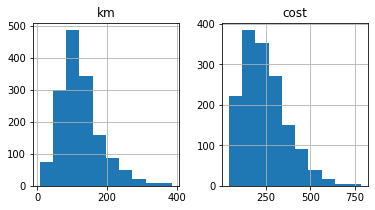

In [152]:
hf3[featers].hist(figsize=(6, 3));

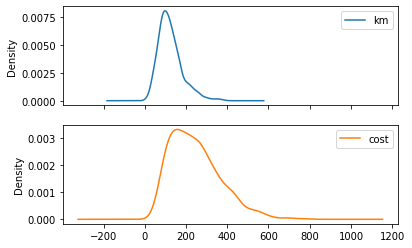

In [153]:
hf3[featers].plot(kind='density', subplots=True);

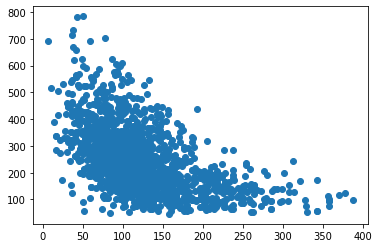

In [154]:
plt.scatter(hf3['km'], hf3['cost']);

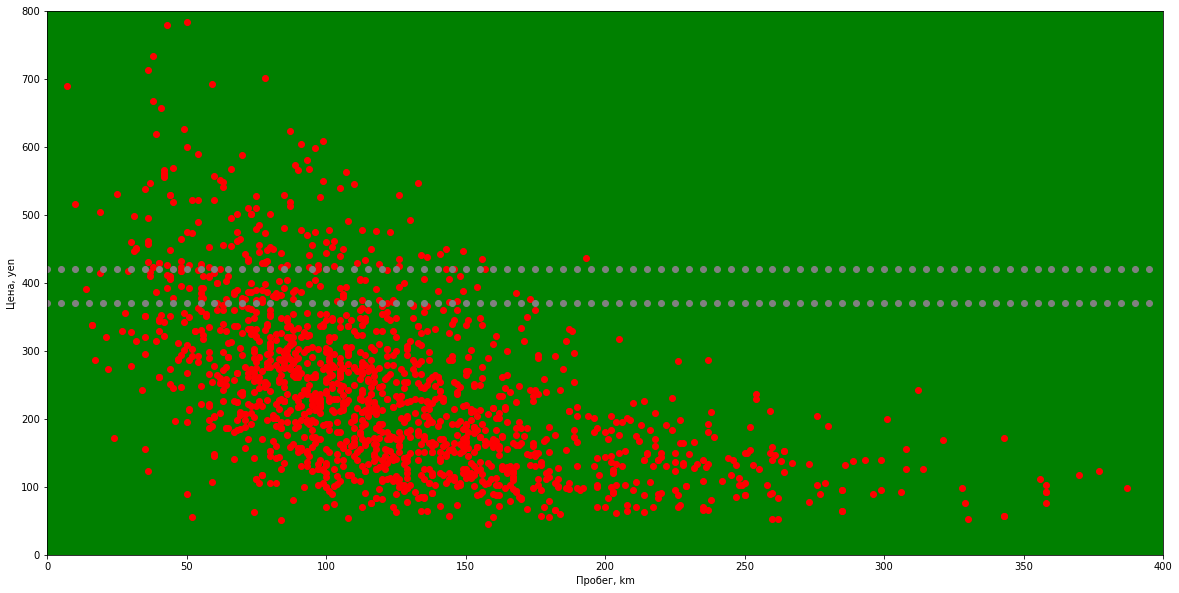

In [221]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

#fig.set(facecolor = 'red')
ax.set(facecolor = 'green')
ax.set_xlim(0, 400)
ax.set_ylim(0, 800)
ax.set_xlabel("Пробег, km")
ax.set_ylabel("Цена, yen")

ax.scatter(hf3['km'], hf3['cost'], color="red")

# Это наш вариант (после лин рег)
ax.scatter(np.arange(0, 400, 5), [370 for _ in range(np.size(np.arange(0, 400, 5)))], color="grey")
ax.scatter(np.arange(0, 400, 5), [420 for _ in range(np.size(np.arange(0, 400, 5)))], color="grey")


plt.show()

In [205]:
[3 for i in rangenp.size(np.arange(0, 400, 10)))

int

In [210]:
v = [8 for i in range(5)]

In [211]:
v

[8, 8, 8, 8, 8]

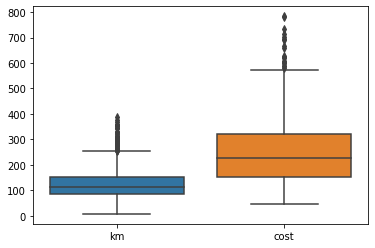

In [156]:
sns.boxplot(data = hf3[featers]);

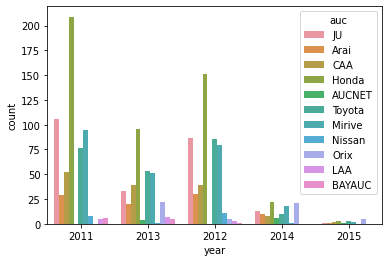

In [157]:
# По годам все падает равномерно
sns.countplot(x = 'year', hue = 'auc', data = hf3);

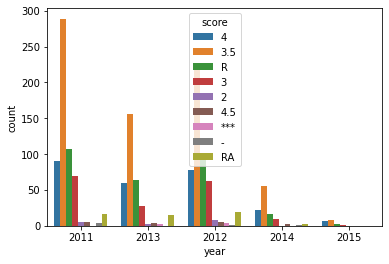

In [158]:
# 3.5 преобладает, а в 2014 году сильно падают R & 4
sns.countplot(x = 'year', hue = 'score', data = hf3, );

***Делаем one-hot категориальных колонок***

In [159]:
# Смотрим, сколько строк в обучающем наборе и запоминаем, потом делить на трэйн и тест будем по этому значению
m = hf3.shape[0]
m

1538

In [160]:
# Объединяем оба датасета
h_end = pd.concat([hf3, ht3], axis=0)

# Думаю, где индексы объединить, здесь неверно, потом км не прикручивается
# h_end.reset_index(drop=True, inplace=True)

# Проверяем, чтобы по строкам объединились!
h_end.shape[0] == hf3.shape[0] + ht3.shape[0]

True

In [161]:
# Категориальная часть признаков
hf_cat = h_end[cat_col]

In [162]:
hf_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 7
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   auc     1545 non-null   object
 1   mod     1545 non-null   object
 2   year    1545 non-null   object
 3   color   1545 non-null   object
 4   score   1545 non-null   object
dtypes: object(5)
memory usage: 72.4+ KB


In [163]:
hf_cat.iloc[1538:, :]

,auc,mod,year,color,score
0,Toyota,PREM,2012,GRAY,R
1,Toyota,SMART,2011,BLACK,2
2,Toyota,SMART,2011,PEARL,3
3,Toyota,PREM,2011,BLUE,RA
4,Arai,PREM,2011,GRAY,4
5,Arai,PREM,2011,SILVER,RA
7,Arai,PREM,2011,PEARL,3.5


In [164]:
hf_cat_OH = pd.get_dummies(hf_cat)

In [165]:
hf_cat_OH.shape

(1545, 42)

***Масштабируем km***

In [166]:
"""
mean_km = hf3['km'].describe()['mean']
std_km = hf3['km'].describe()['std']

hf3['km'] = hf3['km'].apply(lambda km: (km - mean_km) / std_km)

mean_t_km = ht3['km'].describe()['mean']
std_t_km = ht3['km'].describe()['std']

ht3['km'] = ht3['km'].apply(lambda km: (km - mean_t_km) / std_t_km)

# Посмотрим на значения, получилось отлично
hf3['km'].describe()
"""

"\nmean_km = hf3['km'].describe()['mean']\nstd_km = hf3['km'].describe()['std']\n\nhf3['km'] = hf3['km'].apply(lambda km: (km - mean_km) / std_km)\n\nmean_t_km = ht3['km'].describe()['mean']\nstd_t_km = ht3['km'].describe()['std']\n\nht3['km'] = ht3['km'].apply(lambda km: (km - mean_t_km) / std_t_km)\n\n# Посмотрим на значения, получилось отлично\nhf3['km'].describe()\n"

***Завершаем, формируем Х и у***

In [167]:
# Общий столбец с км

km = pd.concat([hf3['km'], ht3['km']], axis=0)
km.shape

(1545,)

In [168]:
# Вот конечный датасет! Его делим вручную на обучающие выборки и тестовые
# А можем часть целиком использовать как трэйн, а по части данных сделать предикт
hf4 = pd.concat([hf_cat_OH, km], axis=1)
hf4.shape

(1545, 43)

***Это для тестирования на всех данных, которые известны***

In [169]:
X_t = hf4.iloc[:1538, :]
X_t.shape

(1538, 43)

In [170]:
X_t.columns

Index(['auc_AUCNET', 'auc_Arai', 'auc_BAYAUC', 'auc_CAA', 'auc_Honda',
       'auc_JU', 'auc_LAA', 'auc_Mirive', 'auc_Nissan', 'auc_Orix',
       'auc_Toyota', 'mod_C', 'mod_FA IN LINE', 'mod_PREM', 'mod_SMART',
       'year_2011', 'year_2012', 'year_2013', 'year_2014', 'year_2015',
       'color_BLACK', 'color_BLUE', 'color_BLUE GREEN', 'color_BROWN',
       'color_GRAY', 'color_GREEN', 'color_PEARL', 'color_PEARL WHITE',
       'color_PURPLE', 'color_RED', 'color_SILVER', 'color_TEA', 'color_WHITE',
       'score_2', 'score_3', 'score_3.5', 'score_4', 'score_4.5', 'score_***',
       'score_-', 'score_R', 'score_RA', 'km'],
      dtype='object')

In [171]:
y_t = hf3['cost']
y_t.shape

(1538,)

## Sklearn

In [172]:
# Разделим данные для тестирования
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_t, y_t, train_size=0.7, random_state=42)

# Посмотрим результат!
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1076, 43), (462, 43), (1076,), (462,))

In [173]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [174]:
model = LinearRegression().fit(X_train, y_train)

In [175]:
# Не совсем понятно, что показывает скор. Хорошо это или плохо? Идеально 1, плохо 0 и сколь-угодно в минус
model.score(X_test, y_test)

0.5663137223057153

In [176]:
from sklearn.metrics import mean_squared_error

In [177]:
predict_tr = model.predict(X_train)
predict_tst = model.predict(X_test)

In [178]:
# Средне-квадратичная ошибка! Как то веливовато(
print(mean_squared_error(y_train, predict_tr))
print(mean_squared_error(y_test, predict_tst))

5378.149240488035
5968.343140399561


***Если хотим поиграться, напишем ф-ю для линейной регресии и ее оценки по MSE и MAE. MAE в данном случае мне кажется предпочтительнее*** 

In [91]:
def mae_linreg(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,random_state=42)
    
    lr = LinearRegression().fit(X_train, y_train)
    lr_pred = lr.predict(X_test)
        
    return mean_absolute_error(y_test, lr_pred)

### Возьмем другую выборку.

Не будем ничего делить. Возьмем весь датасет X_t как X_train,

In [179]:
X_train = hf4.iloc[:1538, :]
X_test = hf4.iloc[1538:, :]
y_train = hf4.iloc[:1538, :]

In [180]:
hf4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1545 entries, 0 to 7
Data columns (total 43 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   auc_AUCNET         1545 non-null   uint8
 1   auc_Arai           1545 non-null   uint8
 2   auc_BAYAUC         1545 non-null   uint8
 3   auc_CAA            1545 non-null   uint8
 4   auc_Honda          1545 non-null   uint8
 5   auc_JU             1545 non-null   uint8
 6   auc_LAA            1545 non-null   uint8
 7   auc_Mirive         1545 non-null   uint8
 8   auc_Nissan         1545 non-null   uint8
 9   auc_Orix           1545 non-null   uint8
 10  auc_Toyota         1545 non-null   uint8
 11  mod_C              1545 non-null   uint8
 12  mod_FA IN LINE     1545 non-null   uint8
 13  mod_PREM           1545 non-null   uint8
 14  mod_SMART          1545 non-null   uint8
 15  year_2011          1545 non-null   uint8
 16  year_2012          1545 non-null   uint8
 17  year_2013        

In [181]:
mod_linreg1 = LinearRegression()
linreg1 = mod_linreg1.fit(X_train, y_train)

In [182]:
lr_test_pred1 = linreg1.predict(X_test)

In [183]:
lr_test_pred1.shape

(7, 43)

In [184]:
lr_test_pred1[:1, :43]

array([[ 1.08246745e-15, -7.93809463e-15,  2.16493490e-15,
         1.83186799e-15,  6.86950496e-15, -4.74620343e-15,
         1.17961196e-15, -9.71445147e-17,  5.96744876e-16,
         8.60422844e-16,  1.00000000e+00, -1.22124533e-15,
         0.00000000e+00,  1.00000000e+00,  1.66533454e-15,
        -1.24900090e-15,  1.00000000e+00,  3.21964677e-15,
         8.32667268e-17, -2.02615702e-15, -2.10942375e-15,
         1.16573418e-15,  7.07767178e-16, -1.73472348e-15,
         1.00000000e+00,  2.88657986e-15,  1.91513472e-15,
         1.01307851e-15,  8.74300632e-16, -3.19189120e-16,
        -1.58206781e-15, -1.11022302e-16,  1.26287869e-15,
        -4.16333634e-17, -1.29063427e-15,  1.70696790e-15,
        -3.88578059e-16,  1.38777878e-16,  3.74700271e-16,
         1.66533454e-16,  1.00000000e+00,  1.66533454e-16,
         1.02000000e+02]])

In [185]:
X_test.shape

(7, 43)

In [186]:
X_test.T

,0,1,2,3,4,5,7
auc_AUCNET,0,0,0,0,0,0,0
auc_Arai,0,0,0,0,1,1,1
auc_BAYAUC,0,0,0,0,0,0,0
auc_CAA,0,0,0,0,0,0,0
auc_Honda,0,0,0,0,0,0,0
auc_JU,0,0,0,0,0,0,0
auc_LAA,0,0,0,0,0,0,0
auc_Mirive,0,0,0,0,0,0,0
auc_Nissan,0,0,0,0,0,0,0
auc_Orix,0,0,0,0,0,0,0


In [187]:
ans = np.sum(lr_test_pred1 @ np.array(X_test).T, axis=1)

In [188]:
ans

array([64171., 60398., 56625., 39645., 43418., 34612., 96883.])

In [189]:
answer = pd.concat([ht3, pd.DataFrame(ans)], axis=1)

In [190]:
answer.to_excel('answer111_11_07.xlsx')

## Попробуем лин рег только по километражу

In [191]:
inter_feat = ['km', 'year']
hf_sh = hf3[inter_feat] 
hf_cost = hf3['cost']
hf_sh['year'] = hf_sh['year'].astype(int)

In [192]:
inter_feat = ['km']
hf_sh = hf3[inter_feat] 
hf_cost = hf3['cost']

In [193]:
hf_sh.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1538 entries, 0 to 1761
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   km      1538 non-null   int64
dtypes: int64(1)
memory usage: 24.0 KB


In [194]:
X_train, X_test, y_train, y_test = train_test_split(hf_sh, hf_cost, train_size=0.7, random_state=42)

# Посмотрим результат!
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1076, 1), (462, 1), (1076,), (462,))

In [195]:
scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

In [196]:
y_train

1153    103
466     154
360     384
1685    227
892     103
       ... 
1308    282
1488    195
1003    215
1669    168
1304     96
Name: cost, Length: 1076, dtype: int64

In [197]:
model = LinearRegression().fit(X_train, y_train)

In [198]:
model.score(X_test, y_test)

0.290804234765929

In [199]:
X_train_scal

array([[ 0.69171851],
       [-0.55941186],
       [-0.95977358],
       ...,
       [ 0.17458462],
       [-0.29250405],
       [ 2.67684536]])

### Без библ

Функция стоимости
$$
J = {1}/{(2*m)} * \sum_{i=1}^m (h(x_i) * y_i) ** 2; 
$$
$$
h(x_i) = \theta' * X
$$

In [75]:
def cost_func(X, y, theta):
    
    """ Вернет J - стоимость на данной итерации
        Расчет для построения графика зависимости J от кол-ва итераций
        Для оценки работы GD 
        На вход:
        - Х - матрица, размерностью m на n
        - theta - вектор столбец весов, размерностью m на 1
        - y - целевая переменная, вектор р-р m на 1.
    """
    
    m = len(y)
    h = X.T * theta
    pred = h - y
    J = sum(pred ** 2) / (2 * m)
    
    return J


In [76]:
init_theta = 0

In [77]:
def grad_des(X, y, init_theta, alpha, num_iter):
    
    m = len(y)
    h = X.T * theta
    pred = h - y
    theta = init_theta - alpha * sum(pred * ) 

SyntaxError: invalid syntax (3015177543.py, line 6)

In [ ]:
"""Стандартизируем, это не надо, все уже есть
scaler = StandardScaler()
X_train_scal = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)"""

In [78]:
hf_score = hf3["score"]


scaler = StandardScaler()
hf_sc_st = scaler.fit_transform(X_train)
X_test_scal = scaler.transform(X_test)

## Логистическая регрессия, и возможно, другие алгоритмы

**Не все просто с интерпретацией. Результат все же неудовлетворительный!**    
Как вариант можно попробовать перейти от задачи линейной регрессии к задаче классификации. К задаче классификации с 2-мя (неравномерными) классами. Скажем, не в полной мере я понимаю, как это может помочь. Есть ощущение, что так мы искусственно сами делаем часть работы (даже, наверно, большую часть работы) за машину и ей остается построить "линию", отсекающую классы, что например, на графике км/цена, кажется легко достижимым.  
Исходим из того, что у нас есть какой-то максимум бюджета в который нам надо уложиться. Предположим, что этот максимум - 400 тыс йен. Тогда, понимая, что мы хотим в этот бюджет взять нормальную машину, мы не расчитываем на поимку дешевого чуда, но небольшое чудо приветствуется, и не хотим рассматривать слишком дешевые ТС, така как там большой % некачественных машин. Тогда мы можем ограничить и нижнюю границу класса "1".  
Предположим что нижняя граница - 370 тыс йен.При этом тактика ставок будет максимально простой. Ставка будет всегда одна и та же - примерно, середина интервала.  
  
***Тогда класс "1" - машины состоимостью 370 - 420. Остальные - класс "0"***  
  
Так здесь можно и не только лог рег использовать, и деревья и KNN и вместе собрать pipeline.

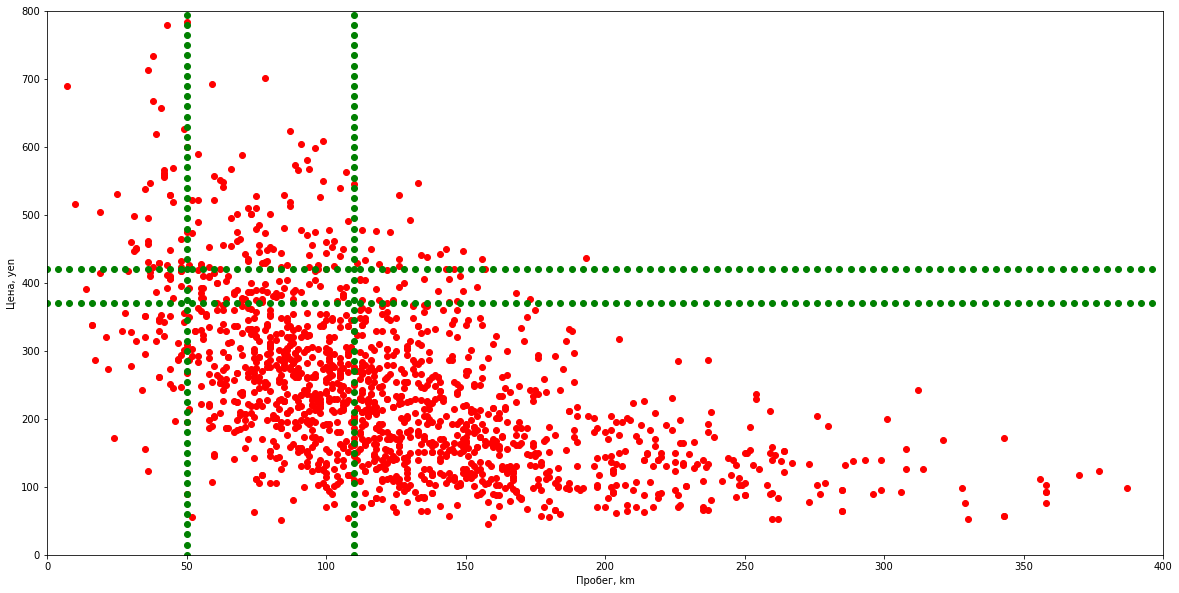

In [229]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

#fig.set(facecolor = 'red')
#ax.set(facecolor = 'grey')  Совсем пестро
ax.set_xlim(0, 400)
ax.set_ylim(0, 800)
ax.set_xlabel("Пробег, km")
ax.set_ylabel("Цена, yen")

ax.scatter(hf3['km'], hf3['cost'], color="red")
# То что будем выбирать
ax.scatter(np.arange(0, 400, 4), [370 for _ in range(np.size(np.arange(0, 400, 4)))], color="green")
ax.scatter(np.arange(0, 400, 4), [420 for _ in range(np.size(np.arange(0, 400, 4)))], color="green")
# Больше для примера, что может попасть
ax.scatter([50 for _ in range(np.size(np.arange(0, 800, 15)))], np.arange(0, 800, 15),  color="green")
ax.scatter([110 for _ in range(np.size(np.arange(0, 800, 15)))], np.arange(0, 800, 15),  color="green")


plt.show()

**Так, наблюдение, а зачем нам изначально машины с пробегами более чем...? Может их сразу выкинуть из данных? Или они нужны? А когда их выкинуть, до или после обучения?**